In [ ]:
# default_exp background_distributions

In [ ]:
#export
import sys
sys.path.append('/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python')
from ms_empire.diffquant_utils import *
from ms_empire.visualizations import *

In [ ]:
#export
from time import time
import numpy as np
class ConditionBackgrounds():

    def __init__(self, normed_condition_df, p2z):
        self.backgrounds = []
        self.ion2background = {}
        self.ion2nonNanvals = {}
        self.idx2ion = {}
        self.init_ion2nonNanvals(normed_condition_df)
        t_start = time()
        self.context_ranges = []
        self.select_intensity_ranges(p2z)
        t_intensity_selection = time()
        print(f't_intensity_selection {t_intensity_selection - t_start}')


    def init_ion2nonNanvals(self, normed_condition_df):
        normed_condition_df['median'] = normed_condition_df.median(numeric_only=True, axis=1)
        normed_condition_df = normed_condition_df.sort_values(by='median').drop('median', axis=1)
        self.normed_condition_df = normed_condition_df
        #nonan_array = get_nonna_array(normed_condition_df.to_numpy())
        #self.ion2nonNanvals = dict(zip(normed_condition_df.index, nonan_array))
        t_start = time()
        self.ion2nonNanvals = get_non_nas_from_pd_df(normed_condition_df)
        t_end = time()
        print(f't_ion2nonan_sw {t_end - t_start}')
        self.idx2ion = dict(zip(range(len(normed_condition_df.index)), normed_condition_df.index))#TODO: list instead of dict!


    def select_intensity_ranges(self, p2z):
        total_available_comparisons =0
        num_contexts = 100
        cumulative_counts = np.zeros(self.normed_condition_df.shape[0])

        for idx ,count in enumerate(self.normed_condition_df.count(axis=1)):
            total_available_comparisons+=count-1
            cumulative_counts[idx] = int(total_available_comparisons/2)


        #assign the context sizes
        context_size = np.max([1000, int(total_available_comparisons/(1+num_contexts/2))])
        halfcontext_size = int(context_size/2)
        context_boundaries = np.zeros(3).astype(int)

        middle_idx = int(np.searchsorted(cumulative_counts, halfcontext_size))
        end_idx = int(np.searchsorted(cumulative_counts, context_size))


        context_boundaries[0] = 0
        context_boundaries[1] = middle_idx
        context_boundaries[2] = end_idx
        while context_boundaries[1] < len(cumulative_counts):
            bgdist = BackGroundDistribution(context_boundaries[0], context_boundaries[2], self.ion2nonNanvals, self.idx2ion, p2z)
            self.context_ranges.append([context_boundaries[0], context_boundaries[2]])
            self.assign_ions2bgdists(context_boundaries[0], context_boundaries[2], bgdist)
            self.backgrounds.append(bgdist)
            context_boundaries[0] = context_boundaries[1]
            context_boundaries[1] = context_boundaries[2]
            end_idx = np.searchsorted(cumulative_counts, context_size + cumulative_counts[context_boundaries[0]])
            if end_idx > len(cumulative_counts)-(context_boundaries[1]-context_boundaries[0])/1.5:
                end_idx = len(cumulative_counts)
            context_boundaries[2] = end_idx

    def assign_ions2bgdists(self, boundaries1, boundaries2, bgdist):
        ion2bg_local = {} #dict(map(lambda _idx : (self.normed_condition_df.index.values[_idx], bgdist), range(boundaries1, boundaries2)))
        for idx in range(boundaries1, boundaries2):
            ion2bg_local.update({self.idx2ion.get(idx) : bgdist})
        self.ion2background.update(ion2bg_local)

In [ ]:
#export
import numpy as np
from random import shuffle
import pandas as pd
from scipy.stats import norm
import math
from time import time

class BackGroundDistribution:

    fc_resolution_factor = 100
    fc_conversion_factor = 1/fc_resolution_factor

    def __init__(self, start_idx, end_idx, ion2noNanvals, idx2ion,p2z):
        self.fc2counts = {} #binned Fold change Distribution
        self.cumulative = np.array([])
        self.zscores = np.array([])
        self.min_fc =0
        self.max_fc = 0
        self.min_z=0
        self.max_z=0
        self.start_idx = int(start_idx)
        self.end_idx = int(end_idx)
        self.var = None
        self.SD = None

        anchor_fcs = self.generate_anchorfcs_from_intensity_range(ion2noNanvals, idx2ion)
        shuffle(anchor_fcs)
        self.generate_fc2counts_from_anchor_fcs(anchor_fcs)
        self.cumulative = self.transform_fc2counts_into_cumulative()
        self.calc_SD(0, self.cumulative)
        self.zscores = self.transform_cumulative_into_z_values(p2z)
       # print(f"create dist SD {self.SD}")

    def generate_anchorfcs_from_intensity_range(self, ion2noNanvals, idx2ion):
        anchor_fcs = []
        for idx in range(self.start_idx, self.end_idx):
            vals = ion2noNanvals[idx2ion.get(idx)]
            if vals.size < 2:
                continue
            anchor_idx =  np.random.randint(0, len(vals))
            anchor_val = vals[anchor_idx]
            vals = np.delete(vals, anchor_idx)
            anchor_fcs.extend(vals-anchor_val)
        return anchor_fcs

    def generate_fc2counts_from_anchor_fcs(self,anchor_fcs):

        anchor_fcs = np.array(anchor_fcs)
        for idx in range(1, anchor_fcs.shape[0]):
            fc_binned = np.rint(self.fc_resolution_factor*(0.5*(anchor_fcs[idx-1] - anchor_fcs[idx]))).astype(np.long)
            self.fc2counts[fc_binned] = self.fc2counts.setdefault(fc_binned, 0) + 1

        self.min_fc = min(self.fc2counts.keys())
        self.max_fc = max(self.fc2counts.keys())


    def transform_fc2counts_into_cumulative(self):

        cumulative = np.zeros(self.max_fc - self.min_fc +1).astype(np.long)

        for entry in self.fc2counts.items():
            cumulative[int(entry[0]-self.min_fc)] +=entry[1]
        for idx in range(1,cumulative.shape[0]):
            cumulative[idx] +=cumulative[idx-1]

        return cumulative


    def transform_cumulative_into_z_values(self, p2z):
        total = self.cumulative[-1]
        min_pval = 1/(total+1)
        self.max_z = abs(norm.ppf(max(1e-9, min_pval)))
        zscores = np.zeros(len(self.cumulative))
        zero_pos = -self.min_fc

        normfact_posvals = 1/(total-self.cumulative[zero_pos]+1)
        normfact_negvals = 1/(self.cumulative[zero_pos-1]+1)
        norm_fix = norm()
        for i in range(len(self.cumulative)):
            t_start = time()
            num_more_extreme = 0
            normfact = 0
            if i == zero_pos or i==len(self.cumulative)-1:
                zscores[i] = 0
                continue

            if i < zero_pos:
                num_more_extreme = self.cumulative[i]
                normfact = normfact_negvals
            else:
                num_more_extreme = self.cumulative[-1] - self.cumulative[i+1]
                normfact = normfact_posvals

            p_val = 0.5*max(1e-9, (num_more_extreme+1)*normfact)
            sign = -1 if i<zero_pos else 1
            t_empirical = time()
            zscore = sign*abs(get_z_from_p_empirical(p_val, p2z))
            zscores[i] =  zscore
            t_nd_lookup = time()
            #print(f"t_empirical {t_empirical - t_start} t_zcacl {t_nd_lookup - t_empirical}")
        return zscores


    def calc_zscore_from_fc(self, fc):
        if abs(fc)<self.fc_conversion_factor:
            return 0
        k = int(fc * self.fc_resolution_factor)
        rank = k-self.min_fc
        if rank <0:
            return -self.max_z
        if rank >=len(self.cumulative):
            return self.max_z
        return self.zscores[rank]


    def calc_SD(self, mean, cumulative):
        sq_err = 0.0
        previous =0
        for i in range(len(cumulative)):
            fc = (i+self.min_fc)*self.fc_conversion_factor
            sq_err += (cumulative[i] - previous)*(fc-mean)**2
            previous = cumulative[i]
        total = cumulative[-1]
        var = sq_err/total
        self.var = var
        self.SD = math.sqrt(var)

In [ ]:
#export
from scipy.stats import norm
from numba import jit
from time import time

class SubtractedBackgrounds(BackGroundDistribution):

    def __init__(self, from_dist, to_dist, p2z):
        self.max_fc = None
        self.min_fc = None
        self.var_from = from_dist.var
        self.var_to = to_dist.var
        self.cumulative = None
        max_joined, min_joined, cumulative = subtract_distribs(from_dist, to_dist)
        self.max_fc = max_joined
        self.min_fc = min_joined
        self.cumulative = cumulative
        t_start = time()
        self.fc2counts = transform_cumulative_into_fc2count(self.cumulative,self.min_fc)
        t_cumul_transf = time()
        self.calc_SD(0, self.cumulative)
        t_calc_SD = time()
        self.zscores = self.transform_cumulative_into_z_values(p2z)
        t_calc_zvals = time()
        #print(f"t_cumul {t_cumul_transf-t_start} t_SD {t_calc_SD-t_cumul_transf} t_zval {t_calc_zvals - t_calc_SD}")

def subtract_distribs(from_dist, to_dist):
    min_joined = from_dist.min_fc - to_dist.max_fc
    max_joined = from_dist.max_fc - to_dist.min_fc

    n_from = get_normed_freqs(from_dist.cumulative)
    n_to = get_normed_freqs(to_dist.cumulative)

    min_from = from_dist.min_fc
    min_to = to_dist.min_fc

    joined_init = np.zeros(max_joined-min_joined+1, dtype="long")
    t_start = time()
    joined = get_joined(joined_init, n_from,n_to, min_from, min_to, min_joined)
    t_join = time()
    cumulative = get_cumul_from_freq(joined)
    t_cumul = time()

    return max_joined, min_joined, cumulative

@jit(nopython=True)
def get_joined(joined,n_from, n_to, min_from, min_to, min_joined):
    count_comparisons =0
    for from_idx in range(len(n_from)):
        fc_from = min_from + from_idx
        freq_from = n_from[from_idx]
        for to_idx in range(len(n_to)):
            fc_to = min_to + to_idx
            freq_to = n_to[to_idx]
            fcdiff = fc_from - fc_to
            joined_idx = fcdiff - min_joined
            freq_multiplied = freq_from*freq_to
            joined[joined_idx] += (freq_multiplied)
            count_comparisons+=1
    return joined

In [ ]:
#hide

def test_subtract_distribs():
    from_dist = [1,1,2,1,1]
    to_dist = [1,1,2,1,1]

In [ ]:
#export
def get_subtracted_bg(ion2diffDist, condbg1, condbg2, ion, p2z):
    if ion in ion2diffDist.keys():
        return ion2diffDist.get(ion)
    bg1 = condbg1.ion2background.get(ion)
    bg2 = condbg2.ion2background.get(ion)

    ions_bg1 = set(map(lambda _idx : condbg1.idx2ion.get(_idx), range(bg1.start_idx, bg1.end_idx)))
    ions_bg2 = set(map(lambda _idx : condbg2.idx2ion.get(_idx), range(bg2.start_idx, bg2.end_idx)))
    common_ions = ions_bg1.intersection(ions_bg2)
    subtr_bg = SubtractedBackgrounds(bg1, bg2, p2z)
    for intersect_ion in common_ions:
        ion2diffDist.update({intersect_ion : subtr_bg})
    return subtr_bg

In [ ]:
#export
from scipy.stats import norm

def get_z_from_p_empirical(p_emp,p2z):
    p_rounded = np.format_float_scientific(p_emp, 1)
    if p_rounded in p2z:
        return p2z.get(p_rounded)
    z = norm.ppf(float(p_rounded))
    p2z[p_rounded] = z
    return z

In [ ]:
#export
#get normalized freqs from cumulative

def get_normed_freqs(cumulative):
    normfact = 2**30 /cumulative[-1]
    freqs =get_freq_from_cumul(cumulative)
    for i in range(len(freqs)):
        freqs[i] *= normfact
    return freqs

In [ ]:
#export
#transform cumulative into frequency

def get_freq_from_cumul(cumulative):
    res = np.zeros(len(cumulative), dtype="long")
    res[0] = cumulative[0]
    for i in range(1,len(cumulative)):
        res[i] = cumulative[i]-cumulative[i-1]

    return res

In [ ]:
#export
def transform_cumulative_into_fc2count(cumulative, min_fc):
    res = {}
    for idx in range(1, len(cumulative)):
        fc = idx + min_fc
        res[fc] = cumulative[idx] - cumulative[idx-1]
    return res

In [ ]:
#export
def get_cumul_from_freq(freq):
    res = np.zeros(len(freq), dtype="long")
    res[0] = freq[0]
    for i in range(1,len(freq)):
        res[i] = res[i-1] + freq[i]

    return res

In [ ]:
#hide
def calc_SD( mean, cumulative, min_fc, fc_conversion_factor):
    sq_err = 0.0
    previous =0
    for i in range(len(cumulative)):
        fc = (i+min_fc)*fc_conversion_factor
        sq_err += (cumulative[i] - previous)*(fc-mean)**2
        previous = cumulative[i]
    total = cumulative[-1]
    var = sq_err/total
    return math.sqrt(var)

In [ ]:
#hide
import pandas as pd
import numpy as np
import os
os.chdir("/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python/")



def compare_diffdist(ion2nonan_1_file, idx2ion_1_file, ion2nonan_2_file, idx2ion_2_file, compare_file):

    ion2nonan1, idx2ion1 = read_reformat_infos(ion2nonan_1_file, idx2ion_1_file)
    ion2nonan2, idx2ion2 = read_reformat_infos(ion2nonan_2_file, idx2ion_2_file)
    
    distrib_df = pd.read_csv(compare_file, sep="\t", header = None)
    
    distrib_df[1] = distrib_df[1].apply(lambda _e : np.asarray(eval(_e), dtype=np.float64))
    #distrib_df = distrib_df.transpose()
    dists = distrib_df[1].to_list()
    
    cumul_ref = dists[0]
    raw_ref = dists[1]
    normed_ref = dists[2]
    zval_ref = dists[3]
    
    bg1 = BackGroundDistribution(28433, 29965, ion2nonan1, idx2ion1,{})
    bg2 = BackGroundDistribution(3711, 5873, ion2nonan2, idx2ion2,{})

    bg = SubtractedBackgrounds(bg1, bg2, {})
    cumul = bg.cumulative
    zval = bg.zscores
    raw = get_freq_from_cumul(cumul)
    normed = get_normed_freqs(cumul)

    print(f"{len(cumul_ref)} vs {len(cumul)}")
    print(f"SD is {bg.SD}")

    distribs_aligned_df = pd.DataFrame( {"cumul_ref" : pd.Series(cumul_ref), "cumul" : pd.Series(cumul), "raw_ref" : pd.Series(raw_ref),
    "raw" : pd.Series(raw), "normed_ref" : pd.Series(normed_ref),  "normed" : pd.Series(normed),"zval_ref" : pd.Series(zval_ref),"zval" : pd.Series(zval)})
    #plot_cumhist_dfcols(distribs_aligned_df)
    #scatter_df_columns(distribs_aligned_df)
    



def read_reformat_infos(ion2nonan_file, idx2ion_file):
    ion2nonan_df = pd.read_csv(ion2nonan_file, sep="\t")
    ion2nonan_df["1"] = ion2nonan_df["1"].apply(lambda _e : np.asarray(eval(_e), dtype=np.float32))
    ion2nonan = dict(zip(ion2nonan_df["0"],ion2nonan_df["1"]))
    idx2ion_df = pd.read_csv(idx2ion_file, sep="\t")
    idx2ion = dict(zip(idx2ion_df["0"].astype('int32'),idx2ion_df["1"]))
    return ion2nonan, idx2ion

for i in range(10):
    compare_diffdist("./test_data/ion2nonans_c1.tsv", "./test_data/idx2ion_c1.tsv","./test_data/ion2nonans_c2.tsv", 
"./test_data/idx2ion_c2.tsv", "./test_data/DGSLAWLRPDTK_diffdist_infos.tsv")



1083 vs 1201
SD is 0.6993725082652864
1083 vs 1121
SD is 0.6924899171259398
1083 vs 1130
SD is 0.7012226986917629
1083 vs 1199
SD is 0.6995580335501189
1083 vs 1278
SD is 0.6966782625057067
1083 vs 1265
SD is 0.7074887572381812
1083 vs 1192
SD is 0.6939531710702341
1083 vs 1147
SD is 0.7046945799432474
1083 vs 1124
SD is 0.700372250827143


KeyboardInterrupt: 

991 vs 973
SD is 0.5095603870223863


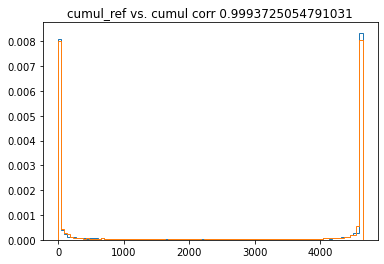

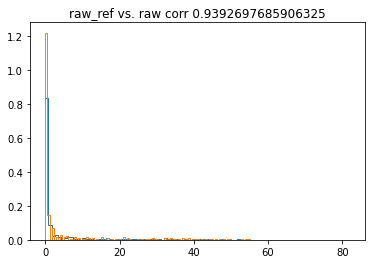

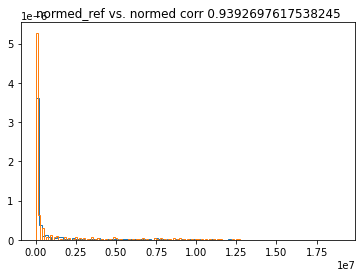

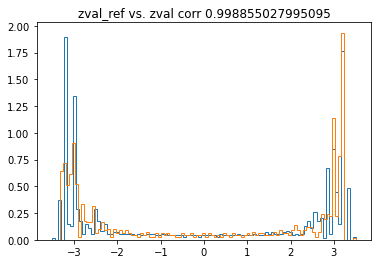

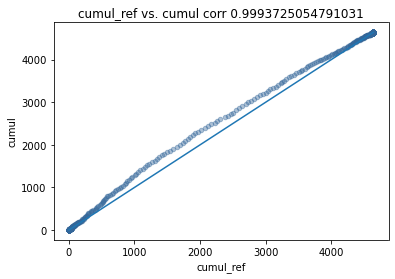

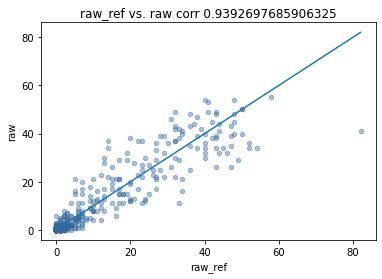

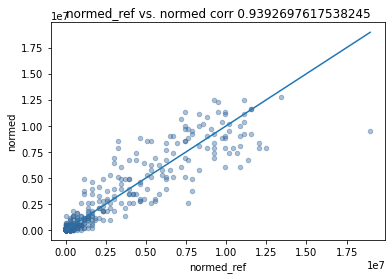

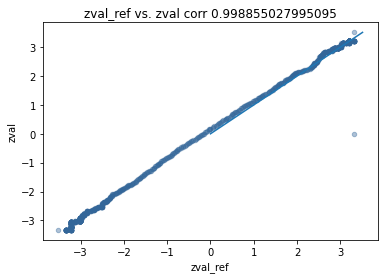

In [ ]:
#hide
import pandas as pd
import numpy as np
import os
os.chdir("/Users/constantin/workspace/EmpiRe/nbdev/MS-EmpiRe_Python/")

def init_compare_bgdist(ion2nonan_file, idx2ion_file, compare_file):
    ion2nonan_df = pd.read_csv(ion2nonan_file, sep="\t")
    ion2nonan_df["1"] = ion2nonan_df["1"].apply(lambda _e : np.asarray(eval(_e), dtype=np.float32))
    ion2nonan = dict(zip(ion2nonan_df["0"],ion2nonan_df["1"]))
    idx2ion_df = pd.read_csv(idx2ion_file, sep="\t")
    idx2ion = dict(zip(idx2ion_df["0"].astype('int32'),idx2ion_df["1"]))
    
    distrib_df = pd.read_csv(compare_file, sep="\t", header = None)
    
    distrib_df[1] = distrib_df[1].apply(lambda _e : np.asarray(eval(_e), dtype=np.float64))
    #distrib_df = distrib_df.transpose()
    dists = distrib_df[1].to_list()
    
    cumul_ref = dists[0]
    raw_ref = dists[1]
    normed_ref = dists[2]
    zval_ref = dists[3]

    bg = BackGroundDistribution(0, 2594, ion2nonan, idx2ion,{})

    cumul = bg.cumulative
    zval = bg.zscores
    raw = get_freq_from_cumul(cumul)
    normed = get_normed_freqs(cumul)

    print(f"{len(cumul_ref)} vs {len(cumul)}")
    print(f"SD is {bg.SD}")

    distribs_aligned_df = pd.DataFrame( {"cumul_ref" : pd.Series(cumul_ref), "cumul" : pd.Series(cumul), "raw_ref" : pd.Series(raw_ref),
    "raw" : pd.Series(raw), "normed_ref" : pd.Series(normed_ref),  "normed" : pd.Series(normed),"zval_ref" : pd.Series(zval_ref),"zval" : pd.Series(zval)})
    plot_cumhist_dfcols(distribs_aligned_df)
    scatter_df_columns(distribs_aligned_df)


init_compare_bgdist("./test_data/ion2nonans_c2.tsv", "./test_data/idx2ion_c2.tsv", "./test_data/c2_bgdist_infos_res.tsv")

In [ ]:
def generate_random_input(num_pep,sample2cond_df ):
    pepnames = list(map(lambda _idx : str(uuid.uuid4()), range(num_pep))) #gives uuid strings for each peptide
    randarrays = 10+ 1.5*np.random.randn(num_pep,sample2cond_df.shape[0])
    df_intens = pd.DataFrame(randarrays, columns= sample2cond_df["sample"].tolist())
    df_intens.insert(0, "peptides", pepnames )
    df_intens = df_intens.set_index("peptides")
    return df_intens

sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3'], 'condition' : ['A', 'A', 'A', 'B', 'B', 'B']})
fixed_input = generate_random_input(1000, sample2cond_df)

In [ ]:
#hide
import pandas as pd
import numpy as np
import uuid


def test_condition_backgrounds(unnormed_df):
    condbg = ConditionBackgrounds(unnormed_df)
    nonbg_ions = list(set(condbg.ion2nonNanvals.keys()).difference(condbg.ion2background.keys()))
    display(condbg.normed_condition_df)
    
    assert condbg.ion2background.keys() == condbg.ion2nonNanvals.keys()


test_condition_backgrounds(fixed_input)


TypeError: __init__() missing 1 required positional argument: 'p2z'

In [ ]:
#hide
#test subtract background distribution
from scipy.stats import norm
import matplotlib.pyplot as plt

idx2nonnanvals = {}

for idx in range(2000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    
bgdist1 = BackGroundDistribution(0, 999, idx2nonnanvals)
bgdist2 = BackGroundDistribution(1000, 1999, idx2nonnanvals)

freqdist = get_normed_freqs(bgdist1.cumulative)
plt.bar(range(len(freqdist)),freqdist,width=1,color='g')
plt.show()

subtracted_bgs = SubtractedBackgrounds(bgdist1, bgdist2)

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales

fc2counts_rescaled = tranform_fc2count_to_fc_space(subtracted_bgs.fc2counts, subtracted_bgs.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g')
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, subtracted_bgs.SD)*1.3, color = "red")
axes2.set_ylim(0.0, 0.4)
plt.show()



TypeError: __init__() missing 2 required positional arguments: 'idx2ion' and 'p2z'

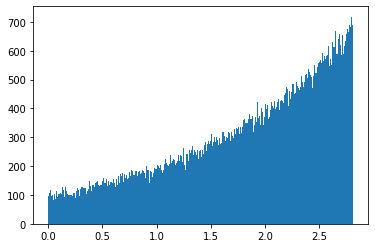

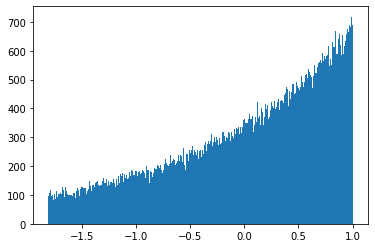

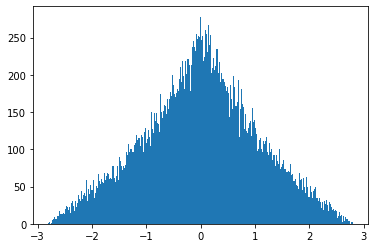

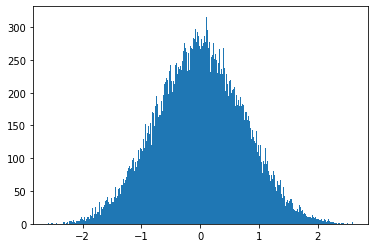

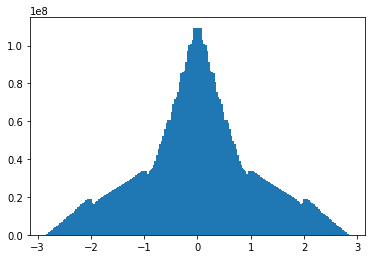

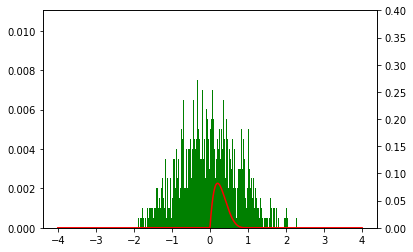

In [ ]:
#hide
#test background distribution
from scipy.stats import norm
from scipy.stats import beta
import matplotlib.pyplot as plt
import itertools
from random import shuffle

idx2nonnanvals = {}
idx2ion = {}
all_nonanvals = list()
all_rescaled_nonanvals = list()
for idx in range(100000):
    nonnanvals =  np.log2(np.random.uniform(1, 7,size=3))
    idx2nonnanvals[idx] = nonnanvals
    idx2ion[idx] = idx
    all_nonanvals.extend(nonnanvals)
    all_rescaled_nonanvals.append(nonnanvals[0]-nonnanvals[1])

shuffle(all_rescaled_nonanvals)
rescaled_vals = []
for idx in range(1,len(all_rescaled_nonanvals)):
    resc = (all_rescaled_nonanvals[idx] - all_rescaled_nonanvals[idx-1])*0.5
    rescaled_vals.append(resc)

counts, bins, bars = plt.hist(all_nonanvals, bins=1000)
plt.show()

plt.hist(all_nonanvals - np.log2(3.5), bins=1000)
plt.show()

plt.hist(all_rescaled_nonanvals, bins=1000)
plt.show()

plt.hist(rescaled_vals, bins=1000)
plt.show()

bin2counts = {}
for idxpair in itertools.permutations(list(range(len(bins)-1)), 2):
    bin1 = bins[idxpair[0]]
    bin2 = bins[idxpair[1]]
    count1 = counts[idxpair[0]]
    count2 = counts[idxpair[1]]
    key = bin1-bin2
    if key not in bin2counts.keys():
        bin2counts[key] = 0
    bin2counts[key] = bin2counts[key]+count2*count1



plt.bar(bin2counts.keys(), bin2counts.values(), width=0.1)
plt.show()

bgdist = BackGroundDistribution(0, 1000, idx2nonnanvals, idx2ion, {})

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales

fc2counts_rescaled = tranform_fc2count_to_fc_space(bgdist.fc2counts, bgdist.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g',)
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
#axes2.plot(x, norm.pdf(x, 0, bgdist.SD)/1.15, color ='r')
axes2.plot(x, beta.pdf(x, 2, 5)/30, color = 'r')
axes2.set_ylim(0.0, 0.4)
plt.show()






In [ ]:
import numpy as np
display(np.min([1,2]))

1